In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv

N, T, t_l, t_e, t_changeKt, kspread = None, None, None, None, None, None # Set later depending on country
samplesPerDay = 10

startingTested = 14
daysOffset = 14

contactTotal = np.zeros((3, 3))
contactHome = np.zeros((3, 3))
## Read contact matrices
file = open('data/final_contact_matrix/total.csv')
lines = file.readlines()
file.close()
for i, line in enumerate(lines):
    for j, entry in enumerate(line.split(',')):
        contactTotal[i, j] = float(entry)
        
file = open('data/final_contact_matrix/home.csv')
lines = file.readlines()
file.close()
for i, line in enumerate(lines):
    for j, entry in enumerate(line.split(',')):
        contactHome[i, j] = float(entry)

In [2]:
## THE SIER-X MODEL
def getPreds(beta = 0.2, lockdownLeakiness = 0.5, beta2 = 0.1, plot = False):
    global Nbar, T, t_l, t_e, t_changeKt
    # Total population, N.

    # Initial number of infected and recovered individuals, I0 and R0.
    # Everyone else, S0, is susceptible to infection initially.

    sigma = 1/5.0
    K0 = 1./7
    MU = 1./7
    gamma1 = 1./21
    gamma2 = 1./21
    gamma3 = 1./19
    b1 = beta1
    b2 = 0.1 * beta1
    b3 = 0.002 * beta1
    f = 0.2
    testingFraction = 1./13
    numBins = 3
    adultBins = set([1])
    N = sum(Nbar)
    
#     A0, I0, Xs0, Xa0, Xi0, P0, R0 = 1, 0, 0, 0, 0, 0, 0
    totalInfected = startingTested * 20
    P0 = startingTested; A0 = totalInfected * (1.0 - f) - P0 ;I0 = 0;
    Xs0 = 0;Xa0 = 0;Xi0 = 0; R0 = 0; Xe0 = 0; E0 = f * totalInfected
    
    Pbar0 = [0, P0, 0]
    Rbar0 = [0, 0, 0]
    Abar0 = [0, A0, 0]
    Ibar0 = [0, I0, 0]
    Ebar0 = [0, E0, 0]
    Xabar0 = [0, 0, 0]
    Xibar0 = [0, 0, 0]
    Xebar0 = [0, 0, 0]
    Xsbar0 = [0, 0, 0]
    Sbar0 = [Nbar[i] - Abar0[i] - Ibar0[i] - Ebar0[i] - Xsbar0[i] - Xabar0[i] - Xibar0[i] - Xebar0[i] - Pbar0[i] - Rbar0[i] for i in range(numBins)]
    
    t = np.linspace(0, T, samplesPerDay*T)
    contactLockdown = contactTotal*lockdownLeakiness + contactHome*(1.0 - lockdownLeakiness)
    contactLockdown2 = contactTotal * (lockdownLeakiness**2) + contactHome * (1.0 - lockdownLeakiness**2)

    def deriv(y, t, N, beta):
        assert len(y) == 10 * numBins
        S = list(y[0 * numBins : 1 * numBins])
        A = list(y[1 * numBins : 2 * numBins])
        I = list(y[2 * numBins : 3 * numBins])
        E = list(y[3 * numBins : 4 * numBins])
        Xs = list(y[4 * numBins : 5 * numBins])
        Xa = list(y[5 * numBins : 6 * numBins])
        Xi = list(y[6 * numBins : 7 * numBins])
        Xe = list(y[7 * numBins : 8 * numBins])
        P = list(y[8 * numBins : 9 * numBins])
        R = list(y[9 * numBins : 10 * numBins]) # can be represented as one, but kept for uniformity
        
        if t < t_l or t > t_e:
            k0 = 0
        else:
            k0 = K0
            
        if t > t_changeKt:
            kt = 0.5; kt2 = 0;
        else:
            kt = 0.075; kt2 = 0

        if t > t_e:
            mu = MU
        else:
            mu = 0

        lamNormal, lamLockdown = [None] * 3, [None] * 3
        
        for i in range(numBins):
            # lambda_i for non-lockdown
            current = 0.0
            for j in range(numBins):
                current += contactTotal[i, j] * (I[j] + A[j] + beta2*E[j])
                current += contactLockdown[i, j] * (Xi[j] + Xa[j] + beta2*Xe[j])
                if i in adultBins:
                    current += contactTotal[i, j] * b3 * P[j] #b3 should be there right?
            lamNormal[i] = beta * current
            # lambda_i for lockdown
            current = 0.0
            for j in range(numBins):
                current += contactLockdown[i, j] * (I[j] + A[j] + beta2*E[j])
                current += contactLockdown2[i, j] * (Xi[j] + Xa[j] + beta2*Xe[j])
                if i in adultBins:
                    current += contactLockdown[i, j] * b3 * P[j] #b3 should be there right?
            lamLockdown[i] = beta * current

        dSdt, dAdt, dIdt, dEdt = [], [], [], []
        dXsdt, dXadt, dXidt, dXedt, = [], [], [], []
        dPdt, dRdt = [], []
        for i in range(numBins):
            dSdt.append(- lamNormal[i] * S[i]/N - k0 * S[i] + mu * Xs[i])
            dAdt.append((1.0 - f) * lamNormal[i] * S[i]/N - sigma * A[i] - k0 * A[i] + mu * Xa[i] - kt2 * A[i])
            dIdt.append(sigma * A[i]  - testingFraction * kt * I[i] - k0 * I[i] + mu * Xi[i] - gamma2 * (1 - testingFraction) * I[i])
            dEdt.append(f * lamNormal[i] * S[i] / N - k0 * E[i] + mu * Xe[i] - gamma1 * E[i])

            dXsdt.append(- lamLockdown[i] * Xs[i]/N + k0 * S[i] - mu * Xs[i])
            dXadt.append((1.0 - f) * lamLockdown[i] * Xs[i]/N - sigma * Xa[i] + k0 * A[i] - mu * Xa[i] - kt2 * Xa[i])
            dXidt.append(sigma * Xa[i] - testingFraction * kt * Xi[i] + k0 * I[i] - mu * Xi[i] - gamma2 * (1 - testingFraction) * Xi[i])
            dXedt.append(f * lamLockdown[i] * Xs[i] / N + k0 * E[i] - mu * Xe[i] - gamma1 * Xe[i])

            dPdt.append(testingFraction * kt * (I[i] + Xi[i]) - gamma3 * P[i] + kt2 * (A[i] + Xa[i]))
            dRdt.append(gamma1 * (E[i] + Xe[i]) + gamma2 * (1 - testingFraction) * (I[i] + Xi[i]) + gamma3 * P[i])

        return tuple(dSdt + dAdt + dIdt + dEdt + dXsdt + dXadt + dXidt + dXedt + dPdt + dRdt)

    # Initial conditions vector
    y0 = Sbar0 + Abar0 + Ibar0 + Ebar0 + Xsbar0 + Xabar0 + Xibar0 + Xebar0 + Pbar0 + Rbar0
    y0 = tuple(y0)
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta))
    S = ret.T[0 * numBins : 1 * numBins]
    A = ret.T[1 * numBins : 2 * numBins]
    I = ret.T[2 * numBins : 3 * numBins]
    E = ret.T[3 * numBins : 4 * numBins]
    Xs = ret.T[4 * numBins : 5 * numBins]
    Xa = ret.T[5 * numBins : 6 * numBins]
    Xi = ret.T[6 * numBins : 7 * numBins]
    Xe = ret.T[7 * numBins : 8 * numBins]
    P = ret.T[8 * numBins : 9 * numBins]
    R = ret.T[9 * numBins : 10 * numBins]
    P = P.sum(axis = 0)
    R = R.sum(axis = 0)
    I = I.sum(axis = 0)
    A = A.sum(axis = 0)
    Xi = Xi.sum(axis = 0)
    Xa = Xa.sum(axis = 0)
    if not plot: return P, R
    else: return P, I + Xi + P, P + I + Xi + A + Xa

# temp = getPreds(0.31, 0)

In [4]:
## READ DATA
def readDataIndia(startDate = None):
    # Start reading data from the startDate and subtract the number of confirmed, recovered and dead 
    # at the startDate from all future points
    file = open('data/time_series/india.csv', 'r')
    reader = csv.reader(file)
    confirmedOffset, recoveredOffset, deadOffset = 0, 0, 0
    confirmed, recovered, dead = None, None, None
    i, r = [], []
    for row in reader:
        if startDate is not None and (startDate.strip() == row[0].strip()):
            startDate = None
            confirmedOffset = int(row[2])
            recoveredOffset = int(row[4])
            deadOffset = int(row[6])
        if startDate is None:
            confirmed = int(row[2]) - confirmedOffset
            recovered = int(row[4]) - recoveredOffset
            dead = int(row[6]) - deadOffset
            r.append(recovered + dead)
            i.append(confirmed - r[-1])
    file.close()
    return i, r

def readDataMaharashtra(startIndex = 0):
    file = open('data/time_series/maharashtra.csv', 'r')
    reader = csv.reader(file)
    confirmed, recovered, dead = None, None, None
    count = -1
    i, r = [], []
    for row in reader:
        count += 1
        if count < startIndex: continue
        confirmed = int(row[2])
        recovered = int(row[4])
        dead = int(row[6])
        r.append(recovered + dead)
        i.append(confirmed - r[-1])
    file.close()
    return i, r

# Start from March 01, when the first case in this spread started, adjust counts as needed
# actualI, actualR = readDataIndia(startDate = "01 March")
# T = 50
# t_l = 23 # From 24 March, ignore Janta Curfew?
# t_e = 44
# actualI = np.asarray(actualI); actualR = np.asarray(actualR)
# N = 1300000000

# actualI, actualR = readDataIndia(startDate = "01 March")
# T = 50 - daysOffset
# t_l = 23 - daysOffset# From 24 March, ignore Janta Curfew?
# t_e = 44 - daysOffset
# actualI = np.asarray(actualI[daysOffset:]); actualR = np.asarray(actualR[daysOffset:])
# N = 1300000000


# Maharashtra Data
actualI, actualR = readDataMaharashtra()
actualI = np.asarray(actualI); actualR = np.asarray(actualR)
T = 50 - daysOffset
t_l = 24 - daysOffset
t_e = 24 + 21 - daysOffset
Nbar = [40544482, 60722916, 11106935]
t_changeKt = 1000000000
kspread = 1.0
# temp = getPreds(beta, beta1, plot = True)

In [5]:
# Define loss and search for the best hyperparameters (grid search for now)
def squaredLoss(preds, target):
    loss = ((preds - target) ** 2).sum()
    return loss

eps = 1e-8
def squaredLossExpScale(preds, target):
    preds = np.log(preds + eps)
    target = np.log(target + eps)
    loss = ((preds - target) ** 2).sum()
    return loss

bestLoss = 10000000000
bestBeta, bestBeta1 = -1, -1
bestPreds = None
betaValues = np.linspace(0.0, 0.1, 21)
beta1Values = np.linspace(0.0, 1.0, 21)
losses = np.zeros((len(betaValues), len(beta1Values)))

for i, beta in enumerate(betaValues):
    for j, beta1 in enumerate(beta1Values):
        predI, predR = getPreds(beta = beta, lockdownLeakiness = beta1)
        trimmedPredI = predI[:len(actualI) * samplesPerDay:samplesPerDay]
        trimmedPredR = predR[:len(actualR) * samplesPerDay:samplesPerDay]
        assert len(trimmedPredI) == len(actualI) and len(trimmedPredR) == len(actualR), "Length mismatch"
        loss = squaredLoss(trimmedPredI, actualI)
        losses[i, j] = loss
        
        if loss < bestLoss:
            bestLoss = loss
            bestPreds = predI, predR
            bestBeta = beta; bestBeta1 = beta1
    print(i, bestLoss)

print("Best beta value", bestBeta)
print("Best beta1 value", bestBeta1)
print("Best loss value", bestLoss)

(0, 2516787.7887015333)
(1, 2487453.1652711146)
(2, 2442766.746833442)
(3, 2373366.145094181)
(4, 2263992.339943892)
(5, 2090372.036362172)
(6, 1816314.997469916)
(7, 1396913.6482212185)
(8, 811411.818529153)
(9, 211565.69768817004)
(10, 70797.47175651146)
(11, 34499.58455714637)
(12, 34499.58455714637)
(13, 34499.58455714637)
(14, 34499.58455714637)
(15, 34499.58455714637)
(16, 34499.58455714637)
(17, 34499.58455714637)
(18, 34499.58455714637)
(19, 34499.58455714637)
(20, 34499.58455714637)
('Best beta value', 0.055)
('Best beta1 value', 0.35000000000000003)
('Best loss value', 34499.58455714637)


Total population of Maharashtra: 114200000
Maximum positive cases: 15700739
Maximum symptomatic people: 46460532
Maximum infected people: 60887191


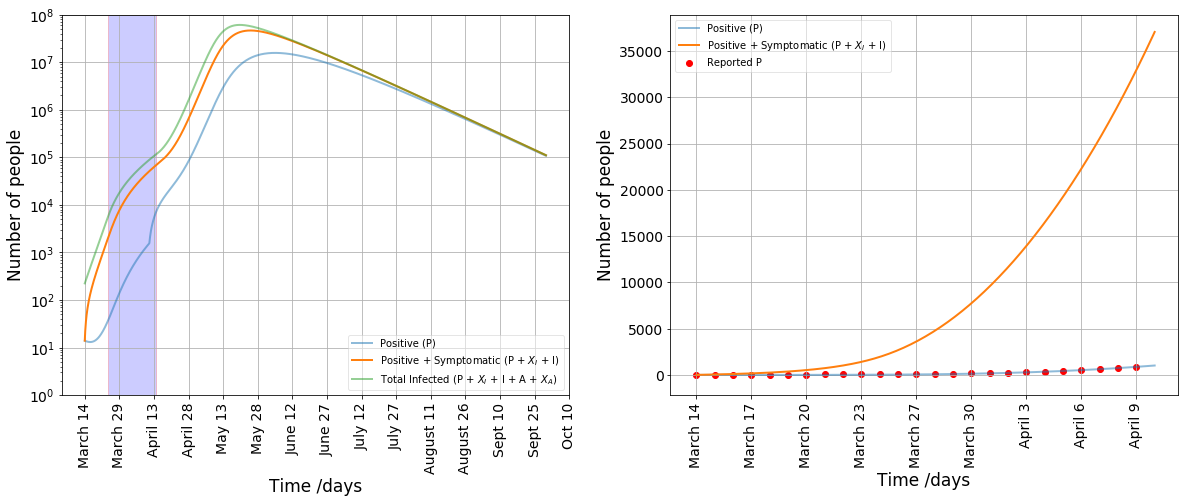

In [6]:
# beta = 0.31; beta1 = 0.25
beta = bestBeta; beta1 = bestBeta1
T = 200; T2 = 25
kspread = 1.0

t_e = 24 + 21 - daysOffset
t_changeKt = 42 - daysOffset
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)

print("Total population of Maharashtra: 114200000")
print("Maximum positive cases: " + str(int(pLock.max() + 0.5)))
print("Maximum symptomatic people: " + str(int(totalLock.max() + 0.5)))
print("Maximum infected people: " + str(int(total2Lock.max() + 0.5)))

fig, (ax, ax2) = plt.subplots(1, 2, facecolor='w', figsize=(20, 7))
t = np.linspace(0, T, samplesPerDay * T + 1)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='Positive (P)')
ax.plot(t[:len(totalLock)], totalLock, lw=2, label='Positive + Symptomatic (P + $X_I$ + I)')
ax.plot(t[:len(total2Lock)], total2Lock, alpha=0.5, lw=2, label='Total Infected (P + $X_I$ + I + A + $X_A$)')
ax.set_xlabel('Time /days', fontsize=17)
ax.set_ylabel('Number of people', fontsize=17)
ax.set_yscale('log')
ax.set_ylim(1, 1e8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.set_xticklabels(['', 'March 14', 'March 29', 'April 13', 'April 28', 'May 13', 'May 28', 'June 12', 'June 27',\
                   'July 12', 'July 27', 'August 11', 'August 26', 'Sept 10', 'Sept 25', 'Oct 10', 'Oct 25',\
                   'Nov 9', 'Nov 24', 'Dec 9', 'Dec 24', 'Jan 8'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
ax.tick_params(labelsize=14)
ax.fill([10,31,31,10], [0,0,10**8,10**8], 'b', alpha=0.2, edgecolor='r')
ax.grid()

t = np.linspace(0, T2, samplesPerDay * T2 + 1)
ax2.plot(t, pLock[:len(t)], alpha=0.5, lw=2, label='Positive (P)')
ax2.plot(t, totalLock[:len(t)], lw=2, label='Positive + Symptomatic (P + $X_I$ + I)')
 #ax2.plot(t, total2Lock[:len(t)], alpha=0.5, lw=2, label='predicted P + Xi + i + A + Xa')
ax2.scatter(list(range(len(actualI))), actualI, c = 'r', label='Reported P')
ax2.set_xlabel('Time /days', fontsize=17)
ax2.set_ylabel('Number of people', fontsize=17)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax2.set_xticklabels(['', 'March 14', 'March 17', 'March 20', 'March 23', 'March 27', 'March 30', 'April 3', \
                    'April 6', 'April 9', 'April 12', 'April 15', 'April 18', 'April 21', 'April 24'], rotation = 'vertical')
legend = ax2.legend()
legend.get_frame().set_alpha(0.5)
ax2.tick_params(labelsize=14)
#ax2.fill([10,31,31,10], [0,0,3000,3000], 'b', alpha=0.2, edgecolor='r')
ax2.grid()
#fig.suptitle('Total population of Maharashtra: 114200000 \n Maximum positive cases:' + str(int(pLock.max() + 0.5))+'\n Maximum symptomatic people:'+ str(int(totalLock.max() + 0.5))+'\n Maximum infected people:' + str(int(total2Lock.max() + 0.5)), y=1.05,fontsize=16)
plt.show()

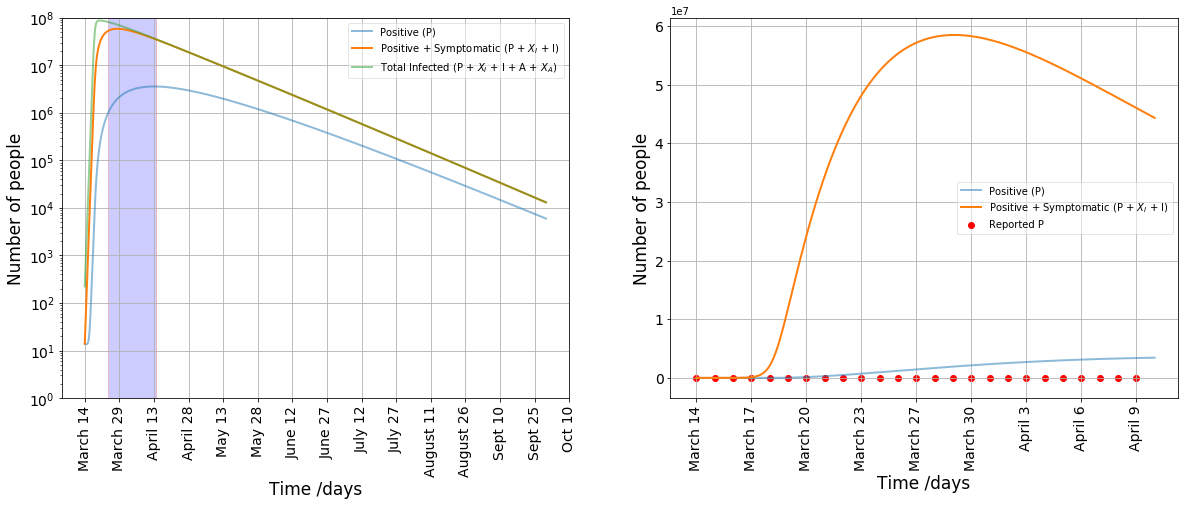

In [7]:
beta = 0.5; beta1 = 0.95
T = 200; T2 = 25
kspread = 0.5

t_e = 24 + 21 - daysOffset
t_changeKt = 10000000000#48 - daysOffset
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)

#print("Total population of Maharashtra: 114200000")
#print("Maximum people tested positive at the same time: " + str(int(pLock.max() + 0.5)))
#print("Maximum people symptomatic at the same time: " + str(int(totalLock.max() + 0.5)))
#print("Maximum people infected at the same time: " + str(int(total2Lock.max() + 0.5)))

fig, (ax, ax2) = plt.subplots(1, 2, facecolor='w', figsize=(20, 7))
t = np.linspace(0, T, samplesPerDay * T + 1)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='Positive (P)')
ax.plot(t[:len(totalLock)], totalLock, lw=2, label='Positive + Symptomatic (P + $X_I$ + I)')
ax.plot(t[:len(total2Lock)], total2Lock, alpha=0.5, lw=2, label='Total Infected (P + $X_I$ + I + A + $X_A$)')
ax.set_xlabel('Time /days', fontsize=17)
ax.set_ylabel('Number of people', fontsize=17)
ax.set_yscale('log')
ax.set_ylim(1, 1e8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.set_xticklabels(['', 'March 14', 'March 29', 'April 13', 'April 28', 'May 13', 'May 28', 'June 12', 'June 27',\
                   'July 12', 'July 27', 'August 11', 'August 26', 'Sept 10', 'Sept 25', 'Oct 10', 'Oct 25',\
                   'Nov 9', 'Nov 24', 'Dec 9', 'Dec 24', 'Jan 8'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
ax.tick_params(labelsize=14)
ax.fill([10,31,31,10], [0,0,10**8,10**8], 'b', alpha=0.2, edgecolor='r')
ax.grid()

t = np.linspace(0, T2, samplesPerDay * T2 + 1)
ax2.plot(t, pLock[:len(t)], alpha=0.5, lw=2, label='Positive (P)')
ax2.plot(t, totalLock[:len(t)], lw=2, label='Positive + Symptomatic (P + $X_I$ + I)')
 #ax2.plot(t, total2Lock[:len(t)], alpha=0.5, lw=2, label='predicted P + Xi + i + A + Xa')
ax2.scatter(list(range(len(actualI))), actualI, c = 'r', label='Reported P')
ax2.set_xlabel('Time /days', fontsize=17)
ax2.set_ylabel('Number of people', fontsize=17)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax2.set_xticklabels(['', 'March 14', 'March 17', 'March 20', 'March 23', 'March 27', 'March 30', 'April 3', \
                    'April 6', 'April 9', 'April 12', 'April 15', 'April 18', 'April 21', 'April 24'], rotation = 'vertical')
legend = ax2.legend()
legend.get_frame().set_alpha(0.5)
ax2.tick_params(labelsize=14)
#ax2.fill([10,31,31,10], [0,0,3000,3000], 'b', alpha=0.2, edgecolor='r')
ax2.grid()
#fig.suptitle('Total population of Maharashtra: 114200000 \n Maximum positive cases:' + str(int(pLock.max() + 0.5))+'\n Maximum symptomatic people:'+ str(int(totalLock.max() + 0.5))+'\n Maximum infected people:' + str(int(total2Lock.max() + 0.5)), y=1.05,fontsize=16)
plt.show()

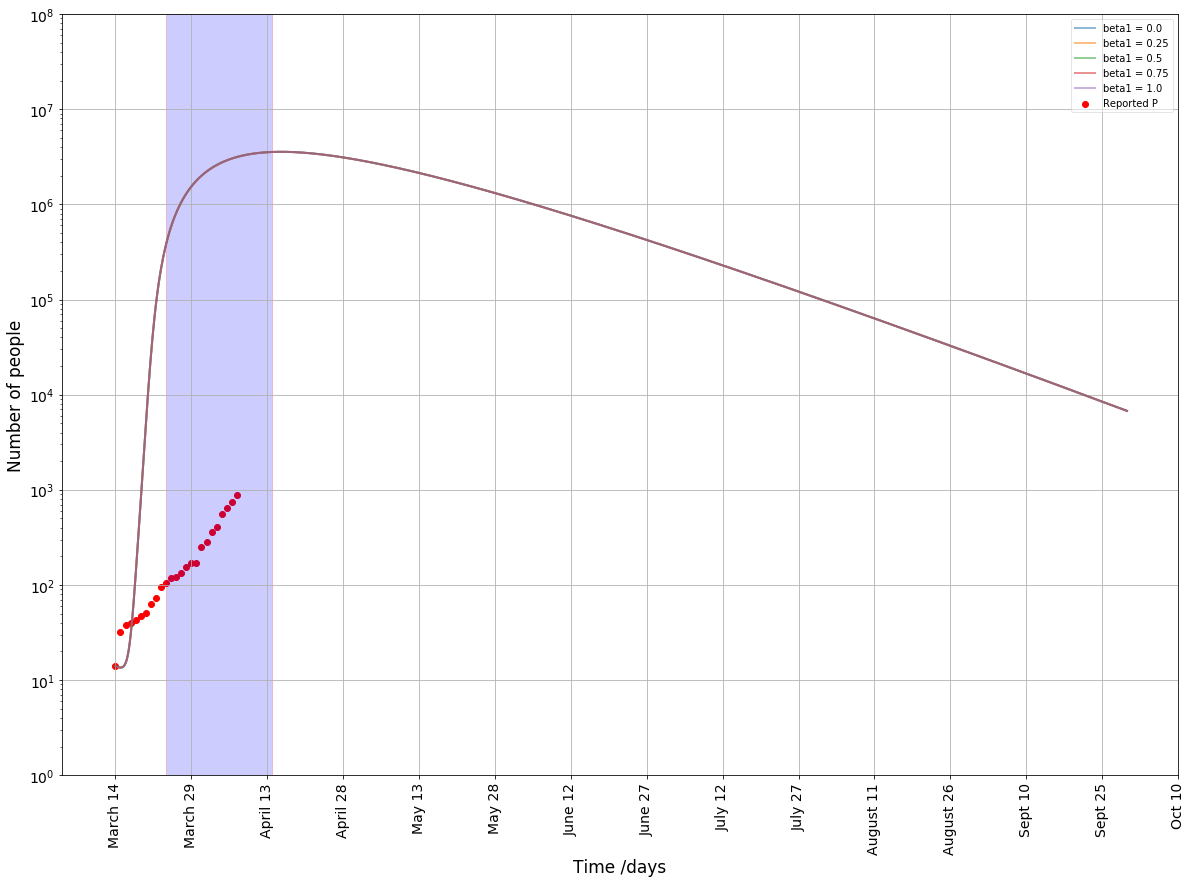

In [8]:
## CHANGE IN P WITH CHANGE IN BETA1
beta = 0.31
T = 200; T2 = 25
kspread = 1.0

t_e = 24 + 21 - daysOffset
t_changeKt = 10000000000#42 - daysOffset

fig, ax = plt.subplots(1, 1, facecolor='w', figsize=(20, 14))
t = np.linspace(0, T, samplesPerDay * T + 1)

beta1 = 0.0
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='beta1 = ' + str(beta1))

beta1 = 0.25
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='beta1 = ' + str(beta1))

beta1 = 0.50
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='beta1 = ' + str(beta1))

beta1 = 0.75
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='beta1 = ' + str(beta1))

beta1 = 1.0
pLock, totalLock, total2Lock = getPreds(beta, beta1, plot = True)
ax.plot(t[:len(pLock)], pLock, alpha=0.5, lw=2, label='beta1 = ' + str(beta1))

ax.scatter(list(range(len(actualI))), actualI, c = 'r', label='Reported P')

# ax.plot(t[:len(totalLock)], totalLock, lw=2, label='Positive + Symptomatic (P + $X_I$ + I)')
# ax.plot(t[:len(total2Lock)], total2Lock, alpha=0.5, lw=2, label='Total Infected (P + $X_I$ + I + A + $X_A$)')
ax.set_xlabel('Time /days', fontsize=17)
ax.set_ylabel('Number of people', fontsize=17)
ax.set_yscale('log')
ax.set_ylim(1, 1e8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.set_xticklabels(['', 'March 14', 'March 29', 'April 13', 'April 28', 'May 13', 'May 28', 'June 12', 'June 27',\
                   'July 12', 'July 27', 'August 11', 'August 26', 'Sept 10', 'Sept 25', 'Oct 10', 'Oct 25',\
                   'Nov 9', 'Nov 24', 'Dec 9', 'Dec 24', 'Jan 8'], rotation = 'vertical')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
ax.tick_params(labelsize=14)
ax.fill([10,31,31,10], [0,0,10**8,10**8], 'b', alpha=0.2, edgecolor='r')
ax.grid()